In [ ]:
import wrapper

import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.keras import layers
import matplotlib.pyplot as plt

Num GPUs Available:  0


In [ ]:
Lx = 1.0
Ly = 1.0
nu = 0.01

def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input(shape=(2,))
    x = layers.Dense(20, activation='tanh')(inputs)
    x = layers.Dense(20, activation='tanh')(x)
    x = layers.Dense(20, activation='tanh')(x)
    outputs = layers.Dense(3)(x)  # u, v, p
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


model = create_model()

# Define the PDE residual
def compute_pde_residual(xy):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(xy)
        up = model(xy)
        u, v, p = up[:, 0], up[:, 1], up[:, 2]
        
        # First derivatives
        u_x = tape.gradient(u, xy)[:, 0]
        u_y = tape.gradient(u, xy)[:, 1]
        v_x = tape.gradient(v, xy)[:, 0]
        v_y = tape.gradient(v, xy)[:, 1]
        p_x = tape.gradient(p, xy)[:, 0]
        p_y = tape.gradient(p, xy)[:, 1]
        
        # Second derivatives
        u_xx = tape.gradient(u_x, xy)[:, 0]
        u_yy = tape.gradient(u_y, xy)[:, 1]
        v_xx = tape.gradient(v_x, xy)[:, 0]
        v_yy = tape.gradient(v_y, xy)[:, 1]
    
    # Continuity equation
    continuity = u_x + v_y
    
    # Momentum equations
    momentum_x = u*u_x + v*u_y + p_x - nu*(u_xx + u_yy)
    momentum_y = u*v_x + v*v_y + p_y - nu*(v_xx + v_yy)
    
    del tape
    
    return continuity, momentum_x, momentum_y

# Boundary conditions
def boundary_conditions():
    # careful, hard coded points count
    xys = generate_bc_data(num_points)
    
    bottom_bc, left_bc, top_bc, right_bc = xys

    bottom_predict = model(bottom_bc)
    left_predict = model(left_bc)
    top_predict = model(top_bc)
    right_predict = model(right_bc)
    
    # inflow
    u, v, p = left_predict[:, 0], left_predict[:, 1], left_predict[:, 2]
    bc_loss = tf.reduce_mean(tf.square(u - (0.5 - tf.abs(0.5 - left_bc[:, 1] / Ly)))) # Full LMAO

    for outflow in [bottom_predict, right_predict, top_predict]:
        u, v, p = outflow[:, 0], outflow[:, 1], outflow[:, 2]
        bc_loss += tf.reduce_mean(tf.square(p))
    return bc_loss

# Training data
def generate_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)
    xy = np.stack([x, y], axis=-1)
    return tf.convert_to_tensor(xy, dtype=tf.float32)

def generate_bc_data(num_points):
    x = np.random.uniform(0, Lx, num_points)
    y = np.random.uniform(0, Ly, num_points)

    bottom = np.zeros(num_points)
    left = np.zeros(num_points)
    top = Ly * np.ones(num_points)
    right = Lx * np.ones(num_points)

    bottom_bc = np.stack([x, bottom], axis=-1)
    left_bc = np.stack([left, y], axis=-1)
    top_bc = np.stack([x, top], axis=-1)
    right_bc = np.stack([right, y], axis=-1)

    # xy = np.concatenate((bottom_bc, left_bc, top_bc, right_bc), axis=None)
    # return tf.convert_to_tensor(xy, dtype=tf.float32)
    
    return (
        tf.convert_to_tensor(bottom_bc, dtype=tf.float32), 
        tf.convert_to_tensor(left_bc, dtype=tf.float32), 
        tf.convert_to_tensor(top_bc, dtype=tf.float32), 
        tf.convert_to_tensor(right_bc, dtype=tf.float32)
        )
    

# Loss function
def loss_function(xy):
    continuity, momentum_x, momentum_y = compute_pde_residual(xy)
    pde_loss = tf.reduce_mean(tf.square(continuity)) + \
               tf.reduce_mean(tf.square(momentum_x)) + \
               tf.reduce_mean(tf.square(momentum_y))
    bc_loss = boundary_conditions()
    total_loss = pde_loss + bc_loss
    return total_loss

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training loop
num_epochs = 10000
num_points = 1000

for epoch in range(num_epochs):
    xy = generate_data(num_points)
    with tf.GradientTape() as tape:
        loss = loss_function(xy)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')

print("Training completed.")

Epoch 0, Loss: 0.5839306712150574
Epoch 100, Loss: 0.02073536068201065
Epoch 200, Loss: 0.019904058426618576
Epoch 300, Loss: 0.018818892538547516
Epoch 400, Loss: 0.017543315887451172
Epoch 500, Loss: 0.017628740519285202
Epoch 600, Loss: 0.013877947814762592
Epoch 700, Loss: 0.007567978464066982
Epoch 800, Loss: 0.002970263361930847
Epoch 900, Loss: 0.0017609645146876574
Epoch 1000, Loss: 0.0012894738465547562
Epoch 1100, Loss: 0.0012174524599686265
Epoch 1200, Loss: 0.0010448575485497713
Epoch 1300, Loss: 0.0009328370215371251
Epoch 1400, Loss: 0.000915400218218565
Epoch 1500, Loss: 0.0008889774908311665
Epoch 1600, Loss: 0.0008397859637625515
Epoch 1700, Loss: 0.0008429771987721324
Epoch 1800, Loss: 0.0007343597244471312
Epoch 1900, Loss: 0.0007624657591804862
Epoch 2000, Loss: 0.0007634044741280377
Epoch 2100, Loss: 0.0006859914865344763
Epoch 2200, Loss: 0.0006699211080558598
Epoch 2300, Loss: 0.0006794403307139874
Epoch 2400, Loss: 0.0006675429176539183
Epoch 2500, Loss: 0.00069

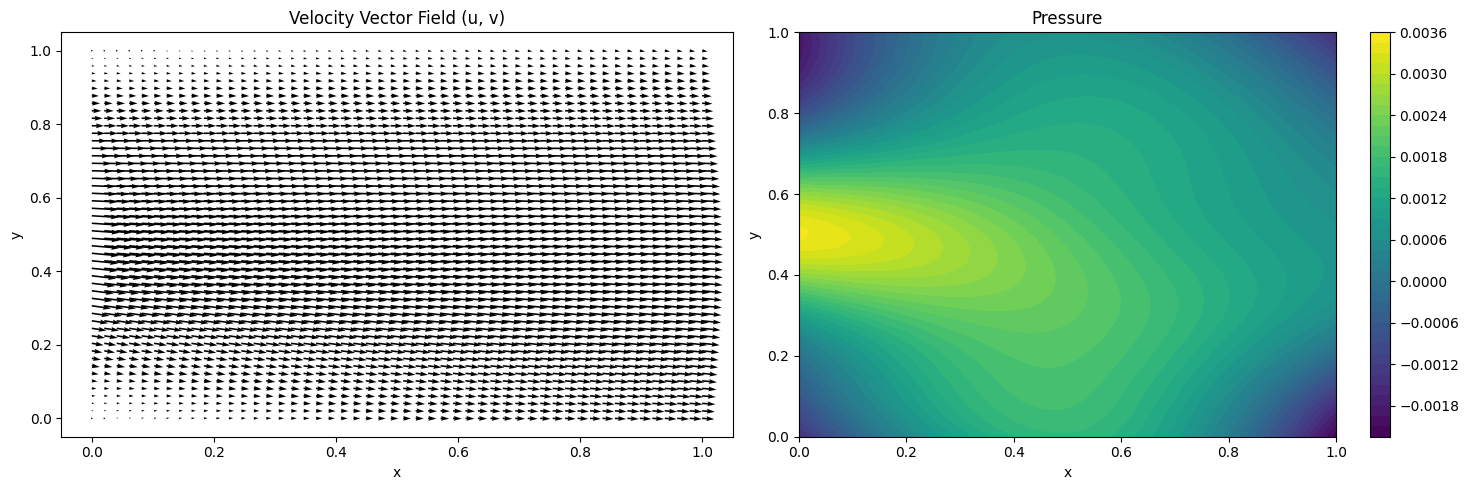

In [9]:
# Visualization
# Generate a grid over the domain
nx, ny = 50, 50
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
X, Y = np.meshgrid(x, y)
XY = np.stack([X.flatten(), Y.flatten()], axis=-1)
XY_tensor = tf.convert_to_tensor(XY, dtype=tf.float32)

# Predict using the trained model
predictions = model(XY_tensor).numpy()
U = predictions[:, 0].reshape((ny, nx))
V = predictions[:, 1].reshape((ny, nx))
P = predictions[:, 2].reshape((ny, nx))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Velocity vector field
axs[0].quiver(X, Y, U, V, scale=10, scale_units='xy')
axs[0].set_title('Velocity Vector Field (u, v)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Pressure
c3 = axs[1].contourf(X, Y, P, levels=50, cmap='viridis')
axs[1].set_title('Pressure')
fig.colorbar(c3, ax=axs[1])
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

plt.tight_layout()
plt.show()